## No augmentarion, pure `EfficientNetV2S` train

In [1]:
import os
import pickle

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.data import Dataset
from tensorflow.keras import optimizers
from tensorflow.keras import losses, metrics
from tensorflow.keras import callbacks

2025-07-03 16:16:45.662699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751527005.729829  669007 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751527005.748322  669007 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751527005.888405  669007 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751527005.888439  669007 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751527005.888441  669007 computation_placer.cc:177] computation placer alr

In [2]:
dataset_path = './datasets/'
butterfly_test = Dataset.load(os.path.join(dataset_path, 'butterfly_test'))
butterfly_train = Dataset.load(os.path.join(dataset_path, 'butterfly_train'))
butterfly_val = Dataset.load(os.path.join(dataset_path, 'butterfly_val'))

I0000 00:00:1751527010.232184  669007 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2b:00.0, compute capability: 8.9


In [3]:
with open('./datasets/class_weights.pkl', 'rb') as f:
    class_weights = {k : v for k, v in enumerate(pickle.load(f))}

In [4]:
v2s_base = EfficientNetV2S(
    include_top=False,
    weights='imagenet',  # W, b initialization (FIXED!!!, DO NOT USE RANDOM INIT WHEN FINE TUNING MODELS)
    input_shape=(260, 260, 3),
    pooling='avg',  # 2D tensor output
    include_preprocessing=True,  # inputs to be float tensors of pixels with values in the [0, 255] range to -> [1, -1]
)

v2s_base.trainable = False  # Freeze base model

# =============== MODEL ===============
inp = layers.Input(shape=(224, 224, 3), name='input')
x = layers.Resizing(260, 260, 
                    interpolation='bilinear',
                    name='resize')(inp)
x = v2s_base(x, training=False)
x = layers.Dropout(0.5)(x)
out = layers.Dense(75, activation='softmax', name='output')(x)
# =============== MODEL ===============

model = Model(inputs=inp, outputs=out, name='EfficientNetV2S_no_augementation')

model.summary()

Model: "EfficientNetV2S_no_augementation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,427,435 (77.92 MB)

 Trainable params: 96,075 (375.29 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [5]:
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
    )
]

model.compile(
    optimizer=optimizers.Adam(learning_rate=.001),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [6]:
history = model.fit(
    butterfly_train,
    validation_data=butterfly_val,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks_list,
)

Epoch 1/50


I0000 00:00:1751527024.708362  669094 service.cc:152] XLA service 0x7f7d5419e890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751527024.708407  669094 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-07-03 16:17:05.374273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751527027.373446  669094 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751527044.846204  669094 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.1319 - loss: 3.8405

2025-07-03 16:17:50.884856: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4349', 156 bytes spill stores, 156 bytes spill loads

2025-07-03 16:17:51.010341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4349', 56 bytes spill stores, 56 bytes spill loads

2025-07-03 16:17:51.029453: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4349', 1148 bytes spill stores, 1148 bytes spill loads

2025-07-03 16:17:51.503742: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4349', 1832 bytes spill stores, 1832 bytes spill loads

2025-07-03 16:17:51.799964: I 

130/130 ━━━━━━━━━━━━━━━━━━━━ 69s 285ms/step - accuracy: 0.1328 - loss: 3.8367 - val_accuracy: 0.5576 - val_loss: 2.4164 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5242 - loss: 2.2567 - val_accuracy: 0.7119 - val_loss: 1.7201 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6724 - loss: 1.6770 - val_accuracy: 0.7634 - val_loss: 1.3662 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7327 - loss: 1.3663 - val_accuracy: 0.7860 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7579 - loss: 1.1571 - val_accuracy: 0.8004 - val_loss: 1.0062 - learning_rate: 0.0010
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8056 - loss: 1.0038 - val_accuracy: 0.8230 - val_loss: 0.9022 - learning_rate: 0.0010
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8119 - loss: 0.8911 - va

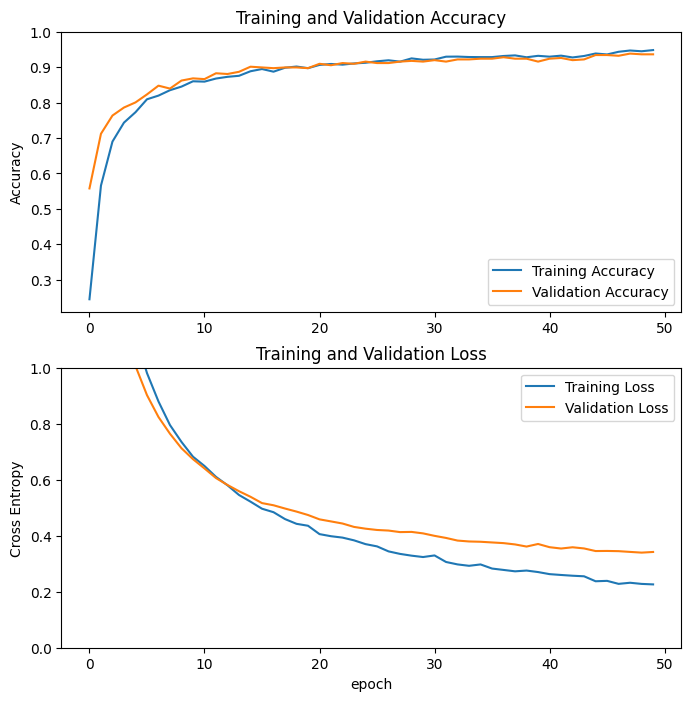

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning

from: https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning

>**Important notes about `BatchNormalization` layer**
>
>Many image models contain `BatchNormalization` layers. That layer is a special case on every imaginable count. Here are a few things to keep in mind.
>
>   `BatchNormalization` contains 2 non-trainable weights that get updated during training. These are the variables tracking the mean and variance of the inputs.
    When you set bn_layer.trainable = False, the `BatchNormalization` layer will run in inference mode, and will not update its mean & variance statistics. This is not the case for other layers in general, as weight trainability & inference/training modes are two orthogonal concepts. But the two are tied in the case of the `BatchNormalization` layer.
    When you unfreeze a model that contains `BatchNormalization` layers in order to do fine-tuning, you should keep the `BatchNormalization` layers in inference mode by passing `training=False` when calling the base model. Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.



\_人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人人\_

＞ `x = v2s_base(x, training=False)` has been done in the model definition!!! ＜

\_^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^Ｙ^\_

In [8]:
v2s_base.trainable = True
print("Number of layers in the base model: ", len(v2s_base.layers))

Number of layers in the base model:  514


In [9]:
fine_tune_at = 400
for layer in v2s_base.layers[:fine_tune_at]:
  layer.trainable = False

len(model.trainable_variables)

99

In [10]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=.0001),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [11]:
fine_tune_history = model.fit(
    butterfly_train,
    validation_data=butterfly_val,
    epochs=len(history.epoch) + 20,
    initial_epoch=len(history.epoch),
    class_weight=class_weights,
    callbacks=callbacks_list,
)

Epoch 51/70
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9029 - loss: 0.3250

2025-07-03 16:24:07.686070: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28501', 424 bytes spill stores, 424 bytes spill loads



130/130 ━━━━━━━━━━━━━━━━━━━━ 83s 304ms/step - accuracy: 0.9031 - loss: 0.3243 - val_accuracy: 0.9280 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 52/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9537 - loss: 0.1388 - val_accuracy: 0.9342 - val_loss: 0.2771 - learning_rate: 1.0000e-04
Epoch 53/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9736 - loss: 0.0837 - val_accuracy: 0.9362 - val_loss: 0.2673 - learning_rate: 1.0000e-04
Epoch 54/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9867 - loss: 0.0523 - val_accuracy: 0.9383 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 55/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9891 - loss: 0.0417 - val_accuracy: 0.9486 - val_loss: 0.2575 - learning_rate: 1.0000e-04
Epoch 56/70
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9932 - loss: 0.0306 - val_accuracy: 0.9342 - val_loss: 0.2926 - learning_rate: 1.0000e-04
Epoch 57/70
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accura

In [12]:
all_acc = acc + fine_tune_history.history['accuracy']
all_val_acc = val_acc + fine_tune_history.history['val_accuracy']

all_loss = loss + fine_tune_history.history['loss']
all_val_loss = val_loss + fine_tune_history.history['val_loss']

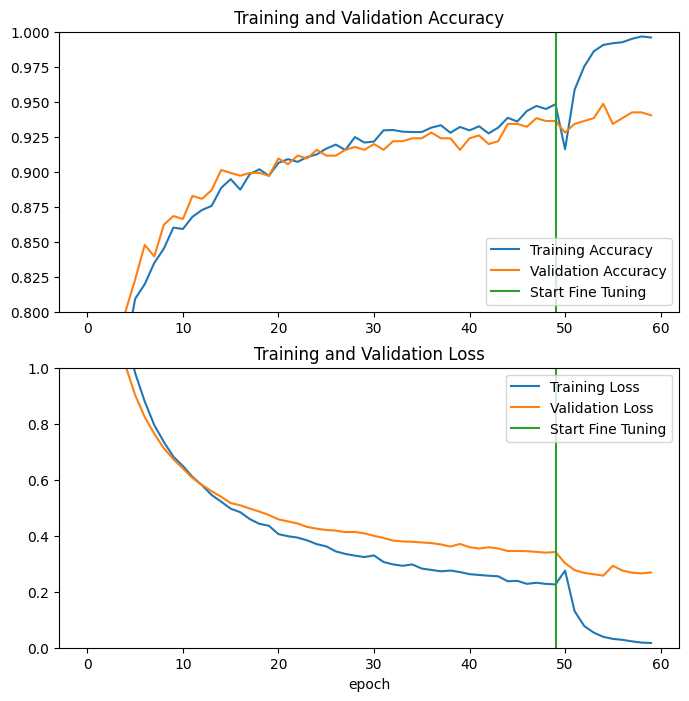

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(all_acc, label='Training Accuracy')
plt.plot(all_val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(all_loss, label='Training Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


slight overfitting observed, but still within margin ($\Delta<6\%$)

`LR=0.0001` as the best test result

In [14]:
results = model.evaluate(butterfly_test)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9305 - loss: 0.2243
Test loss: 0.27899169921875
Test accuracy: 0.9192439913749695
